In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
#import packages and classes
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from GAKELM import GeneticELMRegressor #import genetic algorithm based ELM
from sklearn_extensions.extreme_learning_machines import elm
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM #class for LSTM training
import os
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional #class for bidirectional LSTM as BILSTM
import math
from sklearn import svm

In [3]:
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [4]:
np.set_printoptions(suppress=True)

In [5]:
sc1 = MinMaxScaler(feature_range = (0, 1)) #use to normalize training data
sc2 = MinMaxScaler(feature_range = (0, 1)) #use to normalize label data

In [6]:
#interpolate function to deal with missing values and outliers
def interpolate_nans(X):
    """Overwrite NaNs with column value interpolations."""
    for j in range(X.shape[1]):
        mask_j = np.isnan(X[:,j])
        X[mask_j,j] = np.interp(np.flatnonzero(mask_j), np.flatnonzero(~mask_j), X[~mask_j,j])
    return X

In [7]:
#loading and displaying dataset values
dataset = pd.read_csv("Dataset/Dataset.csv")
dataset.fillna(0, inplace = True)
dataset

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,0.0,0.0,0.92,18.22,17.15,0.0,0.92,27.64,133.36,0.00,0.02,0.00,0.0,0
1,Ahmedabad,2015-01-02,0.0,0.0,0.97,15.69,16.46,0.0,0.97,24.55,34.06,3.68,5.50,3.77,0.0,0
2,Ahmedabad,2015-01-03,0.0,0.0,17.40,19.30,29.70,0.0,17.40,29.07,30.70,6.80,16.40,2.25,0.0,0
3,Ahmedabad,2015-01-04,0.0,0.0,1.70,18.48,17.97,0.0,1.70,18.59,36.08,4.43,10.14,1.00,0.0,0
4,Ahmedabad,2015-01-05,0.0,0.0,22.10,21.42,37.76,0.0,22.10,39.33,39.31,7.01,18.89,2.78,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,Ahmedabad,2016-05-12,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0
498,Ahmedabad,2016-05-13,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0
499,Ahmedabad,2016-05-14,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0
500,Ahmedabad,2016-05-15,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0


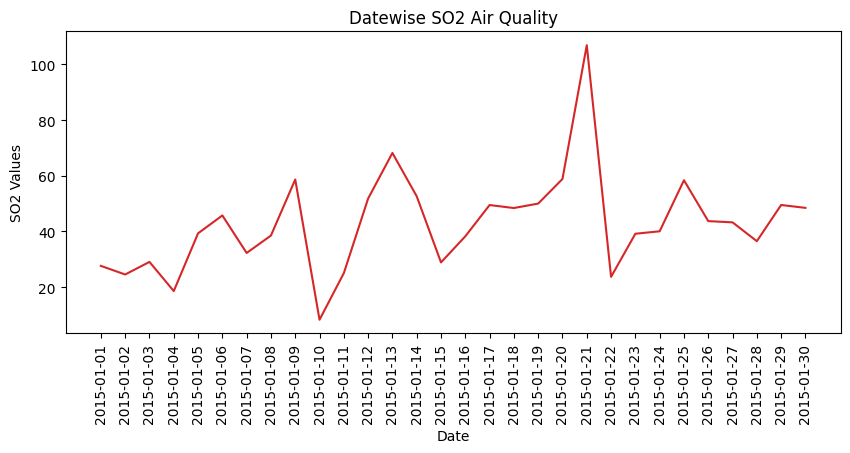

In [8]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot(dataset.Date[0:30], dataset.SO2[0:30], color='tab:red')
plt.gca().set(title="Datewise SO2 Air Quality", xlabel='Date', ylabel="SO2 Values")
plt.xticks(rotation=90)
plt.show()

In [9]:
#dataset preprocessing such as normalization and extracting train and test data from dataset
#extracting X features and Y label from dataset
Y = dataset.values[:,2:3]
dataset.drop(['City'], axis = 1,inplace=True) #removing irrelevant columns
dataset.drop(['Date'], axis = 1,inplace=True)
dataset.drop(['PM2.5'], axis = 1,inplace=True)
dataset.drop(['AQI_Bucket'], axis = 1,inplace=True)
dataset = dataset.values
X = dataset[:,3:dataset.shape[1]-1]

#outlier and missing values removal using interpolation
X = interpolate_nans(X)

X = sc1.fit_transform(X)
Y = sc2.fit_transform(Y)
print("Normalized Training Features")
print(X)

Normalized Training Features
[[0.08532338 0.         0.00633086 ... 0.         0.00012222 0.        ]
 [0.08189055 0.         0.00667492 ... 0.0501499  0.03361036 0.10472222]
 [0.14776119 0.         0.11973576 ... 0.0926683  0.10022    0.0625    ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [77]:
import joblib
scaler_filename = "scaler.save"
joblib.dump(sc1, scaler_filename) 

['scaler.save']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
print("Total records found in dataset  = "+str(X.shape[0]))
print("Total features found in dataset = "+str(X.shape[1]))
print("80% dataset for training : "+str(X_train.shape[0]))
print("20% dataset for testing  : "+str(X_test.shape[0]))

Total records found in dataset  = 502
Total features found in dataset = 8
80% dataset for training : 401
20% dataset for testing  : 101


In [11]:
mse = []
rmse = []
mae = []

mse1 = []
rmse1 = []
mae1 = []
ML_Model = []

#function to call for storing the results
def storeResults(model, a,b,c):
    ML_Model.append(model)
    mse1.append(round(a, 3))
    rmse1.append(round(b, 3))
    mae1.append(round(c, 3))

In [12]:
#function to calculate MSE and other metrics
def calculateMetrics(algorithm, predict, test_labels):
    predict = sc2.inverse_transform(np.abs(predict))
    test_label = sc2.inverse_transform(test_labels)
    predict = predict.ravel()
    test_label = test_label.ravel()
    mse_value = mean_squared_error(test_label, predict) / 100
    rmse_value = math.sqrt(mse_value)
    mse.append(mse_value)
    rmse.append(rmse_value)
    print(algorithm+" MSE  : "+str(mse_value))
    print(algorithm+" RMSE : "+str(rmse_value))
    plt.plot(test_label, color = 'red', label = 'Original Air Quality PM10')
    plt.plot(predict, color = 'green', label = 'Predicted Air Quality PM10')
    plt.title(algorithm+' Air Quality Prediction')
    plt.xlabel('Test Data')
    plt.ylabel('Predicted Air Quality')
    plt.legend()
    plt.show()

# SVR

Existing SVR MSE  : 13.008958711272118
Existing SVR RMSE : 3.6067934112272244


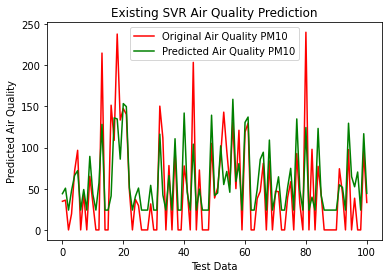

In [13]:
#now train existing SVM algorithm
svm_cls = svm.SVR()
svm_cls.fit(X_train, y_train.ravel())
predict = svm_cls.predict(X_test)
predict = predict.reshape(-1, 1)
calculateMetrics("Existing SVR", predict, y_test)

In [15]:
mse1_value = mean_squared_error(predict, y_test)
rmse1_value = sqrt(mse1_value)
mae1_value = mean_absolute_error(predict, y_test)

storeResults('Existing SVR',mse1_value,rmse1_value,mae1_value)

# GA-KELM

Propose GA-KELM MSE  : 10.239251310334268
Propose GA-KELM RMSE : 3.199883015101375


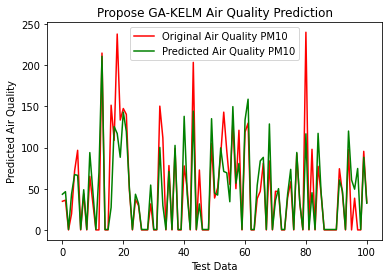

In [16]:
#creating object of genetic EML object by calling class
elm = GeneticELMRegressor()
elm.fit(X_train, y_train)#now train genetic elm on training data
predict2 = elm.predict(X_test) #perform prediction on test data
calculateMetrics("Propose GA-KELM", predict2, y_test)#calculate metrics

In [17]:
mse1_value = mean_squared_error(predict, y_test)
rmse1_value = sqrt(mse1_value)
mae1_value = mean_absolute_error(predict, y_test)

storeResults('Propose GA-KELM',mse1_value,rmse1_value,mae1_value)

# Extension Bi-LSTM

Extension Bi-LSTM MSE  : 5.734123611427277
Extension Bi-LSTM RMSE : 2.3946030175014976


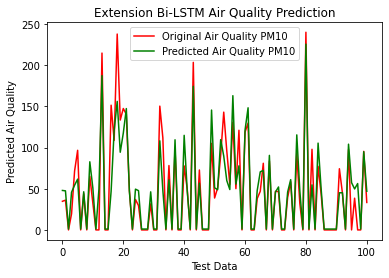

In [18]:
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#now train extension BI-LSTM algorithm
extension = Sequential()
#adding BILSTM 
extension.add(Bidirectional(LSTM(units = 50, input_shape = (X_train1.shape[1], X_train1.shape[2]), return_sequences=True)))
extension.add(Dropout(0.5))
#adding another layer to filter data
extension.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
extension.add(Dropout(0.5))
#adding another layer
extension.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
extension.add(Dropout(0.5))
extension.add(Bidirectional(LSTM(units = 50)))
extension.add(Dropout(0.5))
extension.add(Dense(units = 1))
extension.compile(optimizer = 'adam', loss = 'mean_squared_error')
if os.path.exists('model/extension_weights.hdf5') == False:
    model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
    extension.fit(X_train1, y_train, epochs = 250, batch_size = 4, validation_data=(X_test1, y_test), callbacks=[model_check_point], verbose=1)
else:
    extension = load_model('model/extension_weights.hdf5')
predict = extension.predict(X_test1)
calculateMetrics("Extension Bi-LSTM", predict, y_test)

In [19]:
mse1_value = mean_squared_error(predict, y_test)
rmse1_value = sqrt(mse1_value)
mae1_value = mean_absolute_error(predict, y_test)

storeResults('Extension Bi-LSTM',mse1_value,rmse1_value,mae1_value)

# Comparison

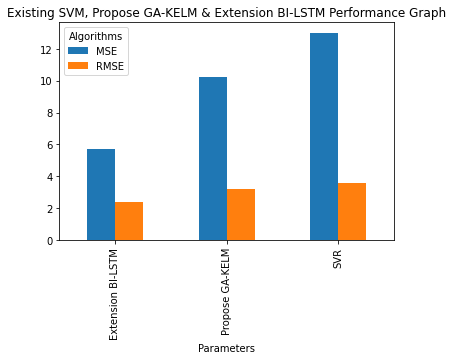

In [20]:
df = pd.DataFrame([['SVR','MSE',mse[0]],['SVR','RMSE',rmse[0]],
                   ['Propose GA-KELM','MSE',mse[1]],['Propose GA-KELM','RMSE',rmse[1]],
                   ['Extension BI-LSTM','MSE',mse[2]],['Extension BI-LSTM','RMSE',rmse[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
plt.title("Existing SVM, Propose GA-KELM & Extension BI-LSTM Performance Graph")
plt.show()

In [21]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'MSE' : mse1,
                       'RMSE': rmse1, 
                       'MAE' : mae1,
                        
                        
                      })

In [22]:
result

,ML Model,MSE,RMSE,MAE
0,Existing SVR,0.023,0.15,0.116
1,Propose GA-KELM,0.023,0.15,0.116
2,Extension Bi-LSTM,0.010,0.10,0.059


In [23]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

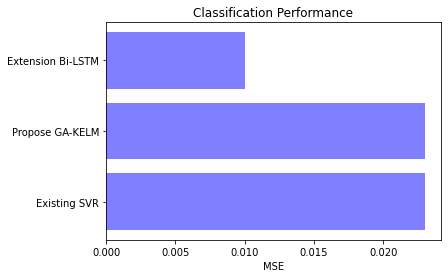

In [27]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos,mse1, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('MSE')
plt2.title('Classification Performance')
plt2.show()


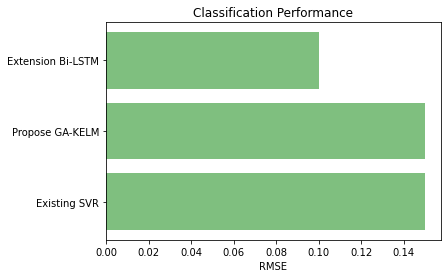

In [28]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos,rmse1, align='center', alpha=0.5,color='green')
plt2.yticks(y_pos, classifier)
plt2.xlabel('RMSE')
plt2.title('Classification Performance')
plt2.show()

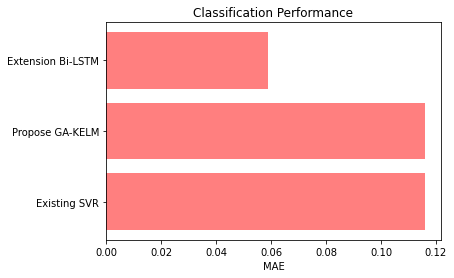

In [29]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos,mae1, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('MAE')
plt2.title('Classification Performance')
plt2.show()

In [30]:
extension.save('model.h5')

# Prediction

In [100]:
from tensorflow.keras.models import Model, load_model
model1 = load_model('model.h5')

In [101]:
X_test.head()

,0,1,2,3,4,5,6,7
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9.514832,0.0,0.231175,25.469202,9.608476,1.177236,1.539709,0.933178
2,38.071266,0.0,28.137341,10.332641,32.747990,0.000000,0.000000,0.000000
3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,27.290973,0.0,7.100385,78.548300,56.391320,0.163505,0.000000,41.259789


In [107]:
int_features = [0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000]

#sc1.fit_transform(int_features)

#int_features = sc1.transform(int_features)
    
dj = np.asarray(int_features)

In [108]:
dj = dj.reshape(-1,8,1)

In [109]:
prediction_proba = model1.predict(dj)

In [110]:
val = prediction_proba[0][0]

In [111]:
pred = sc2.inverse_transform(val.reshape(-1,1))
pred[0][0]

-1.0572579